# FMU Co-Simulation

This example demonstrates how to integrate a **Functional Mock-up Unit (FMU)** as a PathSim block using the co-simulation interface. FMUs are standardized model exchange and co-simulation packages that allow integration of models from different tools.

## What is an FMU?

The [Functional Mock-up Interface](https://fmi-standard.org/) (FMI) is an open standard for model exchange and co-simulation. An FMU is a ZIP archive containing:
- Model equations (compiled binaries)
- XML description of variables and metadata
- Optional resources and documentation

PathSim supports **FMI 2.0** and **FMI 3.0** co-simulation FMUs through the [FMPy](https://github.com/CATIA-Systems/FMPy) library.

## The Coupled Clutches Model

This example uses a **coupled clutches** system, which is a classic benchmark from the FMI standard examples. The system consists of:
- Multiple rotating inertias
- Clutches connecting the inertias
- An input torque driving the system

The FMU has:
- **1 input**: Torque applied to the first clutch
- **4 outputs**: Angular velocities of the four rotating masses

## Import and Setup

Note that FMPy must be installed to use FMU blocks:

```bash
pip install fmpy
```

First, let's import the required classes:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Source, Scope, CoSimulationFMU

## FMU Path

We need to provide the path to the FMU file. In this example, we use the coupled clutches FMU:

In [17]:
from pathlib import Path
notebook_dir = Path().resolve()
fmu_path = notebook_dir / "data" / "CoupledClutches_CS.fmu"

# Verify FMU exists
if not fmu_path.exists():
    raise FileNotFoundError(f"FMU file not found at {fmu_path}")

## Create the FMU Block

In [20]:
# Create FMU block with 10ms communication step size
fmu = CoSimulationFMU(fmu_path, dt=0.01)

# Display FMU metadata
print(f"Model Name: {fmu.model_name}")
print(f"FMI Version: {fmu.fmi_version}")
print(f"Generation Tool: {fmu.generation_tool}")
print(f"Description: {fmu.description}")
print(f"\nCommunication step size: {fmu.dt}s")
print(f"Can interpolate inputs: {fmu.can_interpolate_inputs}")
print(f"Can handle variable step: {fmu.can_handle_variable_step}")

Model Name: CoupledClutches
FMI Version: 2.0
Generation Tool: MapleSim (1196527/1196706/1196706)
Description: Model CoupledClutches

Communication step size: 0.01s
Can interpolate inputs: False
Can handle variable step: True


## System Setup

We create a sinusoidal torque input to drive the system and a scope to record all signals:

In [23]:
# Input torque - sinusoidal excitation
src = Source(lambda t: 0.1 * np.sin(5*t))

# Scope to record all signals
sco = Scope(labels=["Input Torque", "ω₁", "ω₂", "ω₃", "ω₄"])

blocks = [fmu, src, sco]

## Connections

In [26]:
connections = [
    Connection(src[0], fmu[0], sco[0]),  # Input torque to FMU and scope
    Connection(fmu[:4], sco[1:5])        # FMU outputs (4 velocities) to scope
]

## Simulation

The simulation timestep is set smaller than the FMU communication step size. PathSim automatically handles the scheduling of FMU co-simulation steps:

In [29]:
# Initialize simulation
# Use a smaller dt than FMU step size for smoother PathSim integration
sim = Simulation(
    blocks=blocks,
    connections=connections,
    dt=fmu.dt/5,  # PathSim timestep is 5x smaller than FMU step
    log=True
)

# Run simulation for 20 seconds
sim.run(20)

2025-10-11 10:32:08,216 - INFO - LOGGING (log: True)
2025-10-11 10:32:08,217 - INFO - BLOCK (type: CoSimulationFMU, dynamic: False, events: 1)
2025-10-11 10:32:08,217 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-11 10:32:08,217 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-11 10:32:08,218 - INFO - GRAPH (size: 3, alg. depth: 1, loop depth: 0, runtime: 0.061ms)
2025-10-11 10:32:08,218 - INFO - STARTING -> TRANSIENT (Duration: 20.00s)
2025-10-11 10:32:08,219 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-11 10:32:08,245 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: --:--:--) | 2001 steps (77589.1 steps/s)
2025-10-11 10:32:08,269 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: --:--:--) | 4001 steps (83493.7 steps/s)
2025-10-11 10:32:08,291 - INFO - TRANSIENT:  60% | elapsed: 00:00:00 (eta: --:--:--) | 6000 steps (90134.8 steps/s)
2025-10-11 10:32:08,313 - INFO - TRANSIENT:  80% | elapsed: 00:00:00

{'total_steps': 10001,
 'successful_steps': 10001,
 'runtime_ms': 116.0280000185594}

## Results

Let's plot the input torque and the angular velocities of all four clutches:

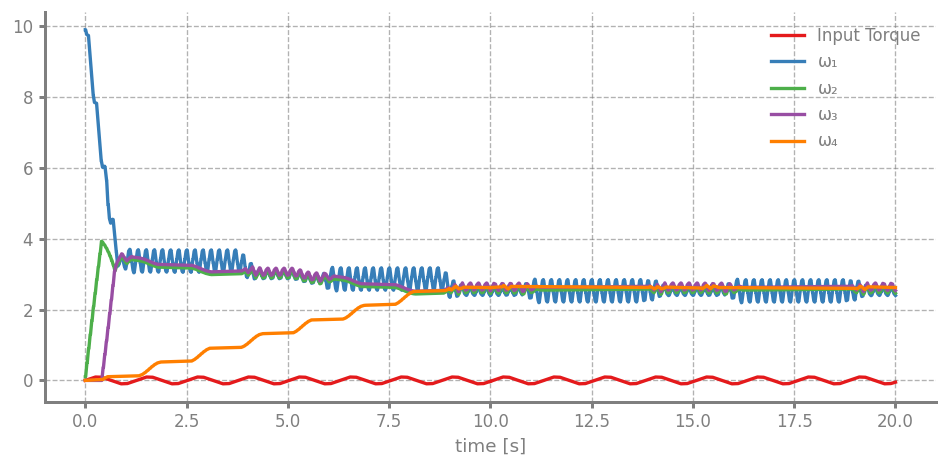

In [32]:
sco.plot()
plt.show()

## Analysis: Phase Space

We can examine the relationship between the angular velocities in phase space:

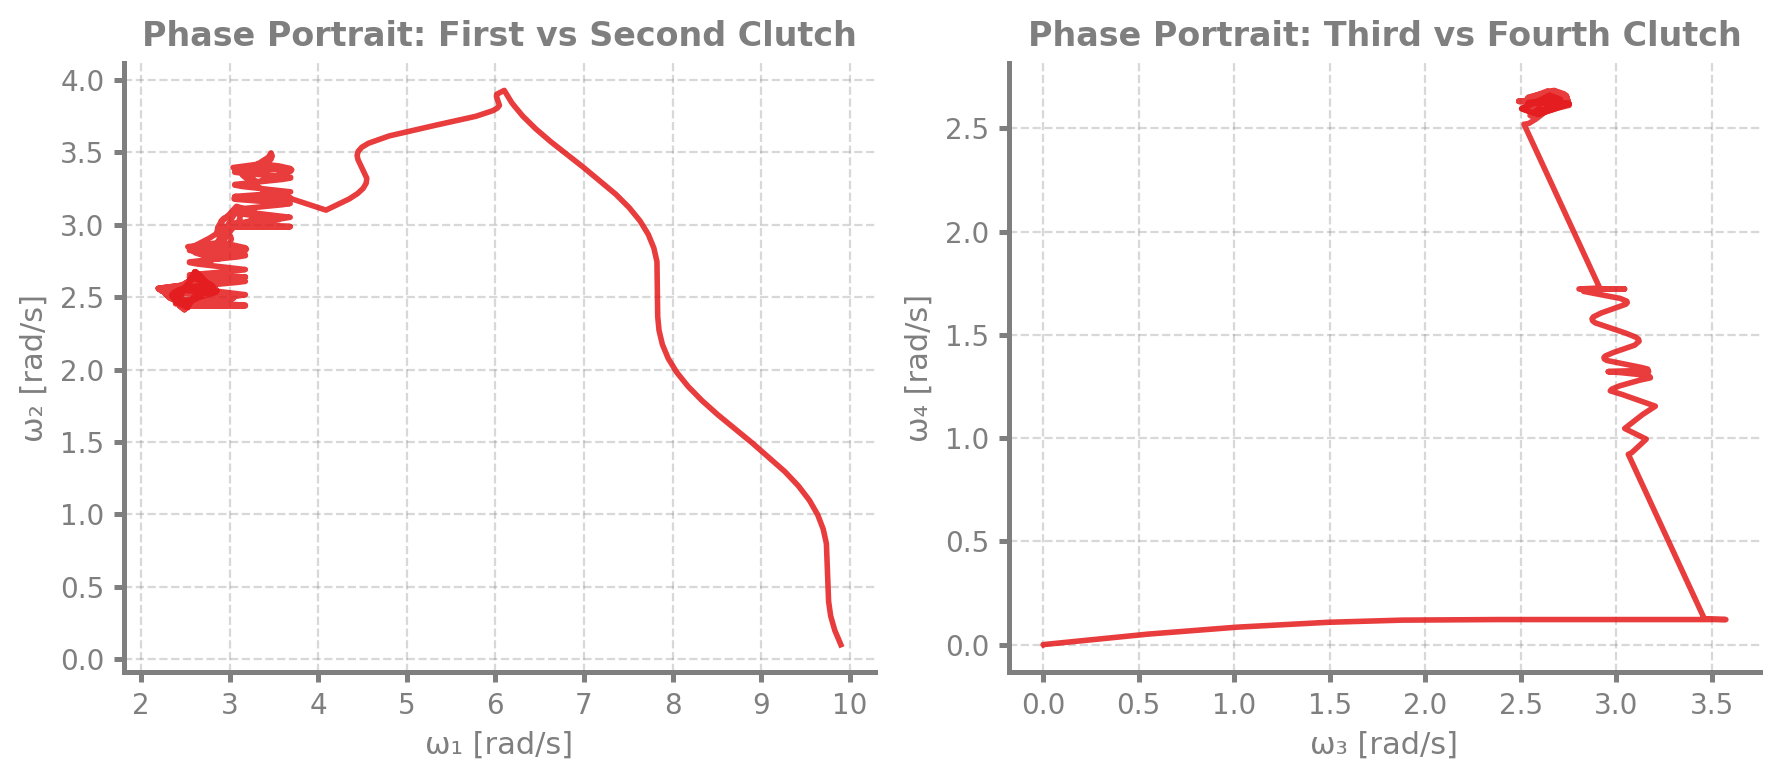

In [37]:
# Get simulation data
time, [torque, w1, w2, w3, w4] = sco.read()

# Phase portrait
fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

# ω₁ vs ω₂
axes[0].plot(w1, w2, alpha=0.85)
axes[0].set_xlabel('ω₁ [rad/s]')
axes[0].set_ylabel('ω₂ [rad/s]')
axes[0].set_title('Phase Portrait: First vs Second Clutch')
axes[0].grid(True, alpha=0.3)

# ω₃ vs ω₄
axes[1].plot(w3, w4, alpha=0.85)
axes[1].set_xlabel('ω₃ [rad/s]')
axes[1].set_ylabel('ω₄ [rad/s]')
axes[1].set_title('Phase Portrait: Third vs Fourth Clutch')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## FMU Integration Details

### Communication Step Size

The FMU performs internal integration steps with its own solver. The `dt` parameter specifies how often PathSim exchanges data with the FMU:

- **Smaller `dt`**: More frequent data exchange, higher accuracy, slower simulation
- **Larger `dt`**: Less frequent exchange, faster simulation, potentially lower accuracy

### PathSim vs FMU Timestep

PathSim can use a different (typically smaller) timestep than the FMU communication interval. This allows:
- Smooth integration with other PathSim blocks
- Fine-grained logging and event detection
- The FMU only performs co-simulation steps at its specified `dt`

### Event Handling

The FMU block uses PathSim's event scheduling system to trigger co-simulation steps at regular intervals. You can see the scheduled events:

In [40]:
# Number of FMU co-simulation steps performed
print(f"Total FMU steps: {len(fmu.events[0])}")
print(f"Expected steps: {int(20/fmu.dt) + 1}")

Total FMU steps: 2001
Expected steps: 2001


### Key Features of CoSimulationFMU

- Supports FMI 2.0 and FMI 3.0 standards
- Automatic metadata extraction and port configuration
- Configurable communication step size
- Event-based synchronization with PathSim
- Full reset and re-initialization support
